In [1]:
!pip install scprep phate scanpy anndata

     |████████████████████████████████| 102kB 4.6MB/s 
     |████████████████████████████████| 10.3MB 8.0MB/s 
     |████████████████████████████████| 122kB 52.8MB/s 
     |████████████████████████████████| 51kB 4.3MB/s 
     |████████████████████████████████| 419kB 37.0MB/s 
     |████████████████████████████████| 1.8MB 42.9MB/s 
     |████████████████████████████████| 71kB 7.4MB/s 
     |████████████████████████████████| 51kB 5.2MB/s 
  Created wheel for sinfo: filename=sinfo-0.3.1-cp37-none-any.whl size=7012 sha256=68dc502318a2ff225ca554d03d641ad46f5c813b421bc78b5813556f581fd421
  Stored in directory: /root/.cache/pip/wheels/11/f0/23/347d6d8e59787c2bc272162d18223dc3b45bd6dc40aceee6af
Successfully built sinfo


In [2]:
import scprep

In [3]:
scprep.io.download.download_google_drive("10FpYcwqXBrG_K0p5Cq936lmH6F9sO70x", 'r_packages.tar.gz')
!tar xzf r_packages.tar.gz  -C /usr/local/lib/R/site-library/ && rm r_packages.tar.gz
!apt-get install -yqq libgsl-dev=2.4+dfsg-6
!pip install --upgrade rpy2
!R -e "BiocManager::install('slingshot')"

Selecting previously unselected package libgslcblas0:amd64.
(Reading database ... 160975 files and directories currently installed.)
Preparing to unpack .../libgslcblas0_2.4+dfsg-6_amd64.deb ...
Unpacking libgslcblas0:amd64 (2.4+dfsg-6) ...
Selecting previously unselected package libgsl23:amd64.
Preparing to unpack .../libgsl23_2.4+dfsg-6_amd64.deb ...
Unpacking libgsl23:amd64 (2.4+dfsg-6) ...
Selecting previously unselected package libgsl-dev.
Preparing to unpack .../libgsl-dev_2.4+dfsg-6_amd64.deb ...
Unpacking libgsl-dev (2.4+dfsg-6) ...
Setting up libgslcblas0:amd64 (2.4+dfsg-6) ...
Setting up libgsl23:amd64 (2.4+dfsg-6) ...
Setting up libgsl-dev (2.4+dfsg-6) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...
Processing triggers for libc-bin (2.27-3ubuntu1.2) ...
/sbin/ldconfig.real: /usr/local/lib/python3.7/dist-packages/ideep4py/lib/libmkldnn.so.0 is not a symbolic link

Requirement already up-to-date: rpy2 in /usr/local/lib/python3.7/dist-packages (3.4.2)

R version 4.0.4

In [5]:
import pandas as pd
import numpy as np
import phate

import matplotlib.pyplot as plt

import os, tarfile

import anndata, scanpy
# matplotlib settings for Jupyter notebooks only
%matplotlib inline

# Comparing trajectory inference algorithms on Treutlein fibroblast data

In this exercise, we will run both Diffusion Pseudotime and Slingshot on a dataset of 392 cells generated from trans-differentiating fibroblasts from [Treutlein et al. _Nature_. 2016](http://doi.org/10.1038/nature18323). This data was already preprocessed and downloaded from the [Dynverse quickstart tutorial](https://dynverse.org/users/2-quick_start/).

Briefly, a variety of transcription factors were overexpressed in Mouse Embryonic Fibroblasts (MEFs) to induce neuronal differentiation. Cells were sampled at several intervals over 22 days of differentation and sequenced using the Fluidigm C1 system and the SMART-seq protocol.

Here, we're doing to work with data that has already been filtered, preprocessed, and normalized so we can get straight to work running trajectory inference algorithms. This preprocessing includes selection of 2000 highly variable genes so the data matrix is 392 cells by 2000 genes.

Unlike the previous exercise, we're going to use the Diffusion Psuedotime (DPT) and Slingshot implementations provided by the original authors of each paper. DPT is provided as part of the excellent [Scanpy](https://scanpy.readthedocs.io/en/stable/) single cell analysis toolkit. Slingshot is only available from the R implementation, so we provided a convenience wrapper in `scprep.run`.

We're breaking this section into the following parts. First, we'll run Slingshot on the Treutlein data. Next, we'll run diffusion pseudotime and compare the results.

## Loading and visualizing the data

#### Download data from Google Drive

Alternatively, you may load your own data by replacing the Google Drive file ids with your own file ids.

Note that if you do, you will likely not have annotated cell types. Replace all references to `metadata['annotated_clusters']` with an entry from `metadata`, or your favorite gene.

In [6]:
scprep.io.download.download_google_drive(id='1DDZkLhC-VlTi-_J7Mxc9_ZmKTuRMfXTG',
                                         destination='data.pickle.gz')
scprep.io.download.download_google_drive(id='1NajeoociZ6FlrW110jFbe___htfhSlNv',
                                         destination='metadata.pickle.gz')
data = pd.read_pickle('data.pickle.gz')
metadata = pd.read_pickle('metadata.pickle.gz')

In [7]:
data.head()

,Hmgb3,Tmem30a,Bloc1s2,Pdcl3,Lyar,Ctsa,Zfp422,Vamp7,Fam114a1,Stmn3,Arl6,Bin3,Phax,Ccm2,Cstf1,Zcchc18,Ccdc6,Mapk3,Ttc35,Tob1,Tax1bp3,Wsb1,Hadhb,Akirin2,Anp32b,Ifngr1,Cklf,Ppdpf,8430410A17Rik,Ctgf,Mphosph10,Pofut2,Inpp4a,Pgam5,Vps4a,Lrrc28,Imp3,Tmed7,4933421E11Rik,Bhlhb9,...,Tubb3,Ifi27l2a,Col1a2,Cdkn1c,Cnn2,Postn,Gja1,Crabp1,Cox6a2,Vim,Itm2a,Anxa3,Eno3,Snca,Tm4sf1,Ifitm3,Fstl1,Anxa2,Tagln2,Arhgdib,Bgn,Cav1,Cox8b,Timp1,Anxa1,Spp1,Tagln,S100a4,Mgp,Tnnt3,Mylpf,Tnnt2,Acta2,S100a6,Pgam2,Tnnc1,Tnni1,Myl1,Tnnc2,Acta1
1_iN1_C01,7.741435,1.795690,0.000000,7.341851,0.000000,6.090298,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.097042,0.000000,7.026617,5.087704,4.237923,4.372745,0.000000,0.000000,0.000000,0.000000,0.000000,5.166766,0.000000,0.000000,0.000000,3.547216,5.728582,0.000000,0.000000,6.659755,6.667227,1.882823,0.000000,3.187801,...,7.689122,0.000000,7.539905,0.000000,0.000000,7.717882,0.000000,7.611547,0.0,7.645521,8.603026,0.000000,0.0,9.307185,0.000000,0.000000,9.208892,3.286225,0.000000,0.000000,8.625152,0.000000,0.000000,4.988722,5.847398,8.234614,0.000000,0.000000,11.399424,3.799204,0.0,0.000000,0.000000,7.340894,7.275953,0.00000,0.000000,5.125307,0.0,0.000000
1_iN1_C02,4.880207,0.000000,0.000000,3.004187,2.383451,5.395503,6.199371,6.619480,2.135299,0.0,0.000000,0.000000,5.576226,0.000000,0.313838,0.000000,4.885249,0.000000,0.000000,0.000000,7.495168,0.000000,0.000000,0.000000,0.000000,0.000000,5.431214,4.341477,0.000000,0.000000,4.178042,5.487762,0.874465,0.000000,0.000000,5.989517,0.000000,0.000000,0.000000,0.000000,...,3.103453,0.000000,7.455024,11.134888,4.497870,0.000000,0.000000,9.690161,0.0,7.468837,4.661921,5.051298,0.0,8.461602,0.000000,3.171609,9.731582,10.325041,4.723340,6.725239,8.756471,7.000997,7.727637,6.881868,2.338303,10.707139,7.502046,7.423766,10.294267,1.340432,0.0,6.471605,4.809379,9.547748,10.265516,8.96431,0.000000,0.000000,0.0,0.000000
1_iN1_C03,2.464102,4.273003,4.019464,1.804309,0.000000,5.430379,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.224092,0.000000,6.063006,6.324300,0.000000,5.265625,6.307448,7.579594,5.454941,4.862937,0.000000,0.000000,0.000000,0.000000,3.998220,0.000000,0.000000,4.644050,0.000000,3.931075,5.259682,0.000000,2.440280,0.000000,0.000000,0.000000,7.117597,...,6.402937,0.000000,5.279984,4.742764,0.000000,0.000000,3.183347,0.000000,0.0,5.746315,5.963933,0.000000,0.0,9.123129,0.000000,5.529175,9.689387,2.575748,0.000000,0.000000,7.568680,0.000000,0.000000,0.000000,0.000000,1.842589,0.000000,0.000000,8.025442,3.130126,0.0,8.493459,0.150616,6.803000,6.231534,0.00000,1.641874,0.000000,0.0,0.000000
1_iN1_C04,0.000000,0.000000,0.000000,7.389080,5.182950,5.322356,0.000000,0.000000,6.769139,0.0,6.783773,0.000000,0.000000,0.000000,0.000000,0.000000,7.494022,0.000000,8.901901,0.000000,0.000000,0.449315,0.000000,0.000000,6.714830,0.000000,1.175611,0.000000,0.000000,0.000000,0.000000,6.109667,0.000000,5.436472,3.303745,0.000000,0.462316,2.909557,0.000000,0.000000,...,0.938401,0.000000,6.891275,0.192726,8.525487,0.000000,0.000000,10.614446,0.0,11.031496,0.000000,7.734287,0.0,0.000000,8.738441,9.780553,11.204102,11.752770,9.066461,11.080285,9.428689,6.623351,0.000000,7.095368,11.410934,0.000000,9.864499,7.932982,1.250348,0.000000,0.0,0.000000,10.419956,13.351129,0.000000,4.51147,0.000000,0.000000,0.0,0.070281
1_iN1_C05,2.087070,0.000000,2.857140,6.667093,4.649816,5.217366,3.211770,1.457797,6.506859,0.0,6.695195,5.121357,3.670509,1.610114,0.000000,0.000000,5.400019,2.806369,7.751262,6.492866,6.568639,5.002074,0.000000,5.077731,6.298271,3.755723,4.984998,5.322460,4.358176,3.193957,4.626951,2.181779,2.939626,0.000000,0.000000,5.838873,4.563482,2.871915,1.126257,0.000000,...,0.000000,6.546523,7.680772,4.719608,5.980427,5.975914,8.482874,5.718936,0.0,9.216041,5.464727,6.212147,0.0,7.000345,6.363985,7.761264,9.532635,10.461818,8.434448,6.027753,8.385129,8.919182,4.770562,8.362844,9.363407,10.604481,8.007021,8.717167,8.504500,3.905870,0.0,1.59

In [8]:
metadata.head()

,annotated_clusters
0,
1_iN1_C01,d2_induced
1_iN1_C02,d2_induced
1_iN1_C03,d2_induced
1_iN1_C04,d2_intermediate
1_iN1_C05,d2_intermediate


#### Run PHATE

In [9]:
phate_op = phate.PHATE()

data_phate = phate_op.fit_transform(data)
data_phate = pd.DataFrame(data_phate, index=data.index)

Calculating PHATE...
  Running PHATE on 392 observations and 2000 variables.
  Calculating graph and diffusion operator...
    Calculating PCA...
    Calculated PCA in 0.33 seconds.
    Calculating KNN search...
    Calculated KNN search in 0.07 seconds.
    Calculating affinities...
    Calculated affinities in 0.03 seconds.
  Calculated graph and diffusion operator in 0.45 seconds.
  Calculating optimal t...
    Automatically selected t = 17
  Calculated optimal t in 0.11 seconds.
  Calculating diffusion potential...
  Calculated diffusion potential in 0.05 seconds.
  Calculating metric MDS...
  Calculated metric MDS in 0.20 seconds.
Calculated PHATE in 0.86 seconds.


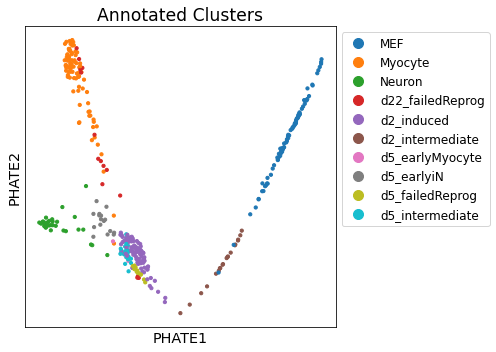

In [10]:
scprep.plot.scatter2d(data_phate, c=metadata['annotated_clusters'],
                      legend_anchor=(1,1),
                      label_prefix='PHATE', ticks=None,
                      title='Annotated Clusters',
                      figsize=(7,5))

## Running Slingshot

[Slingshot](https://doi.org/10.1186/s12864-018-4772-0) is a trajectory inference tool that was reported to be among the top-performing trajectory inference algorithms for simple trajectories. The method has five conceptual steps:

1. Perform dimensionality reduction on the data (e.g. PCA, PHATE, UMAP)
2. Cluster the data
3. Create a minimum spanning tree between the data
4. Fit principal curves to the data
5. Project the data onto the principal curves



### Step 1 - Perform dimensionality reduction

We already did this! For now, let's proceed to Step 2.

**Bonus** If you have extra time later, try using a different dimensionality reduction algorithm by removing the comments at the beginning of the next code block.

In [11]:
# =================
# To run the next two lines, remove the hashtags at the beginning of each line
data_umap = umap.UMAP().fit_transform(data)
data_pca = scprep.reduce.pca(data, n_components=2)
# =================

NameError: ignored

### Step 2 - Cluster the data

Picking the ideal number of clusters here is a little trial and error. Let's try a few different number of clusters and compare.

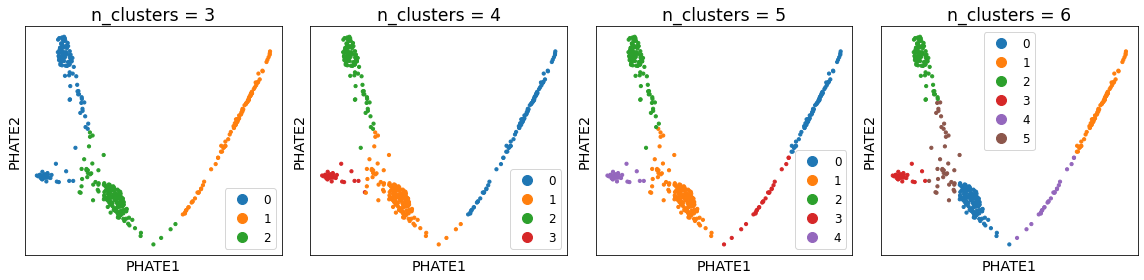

In [12]:
fig, axes = plt.subplots(1,4, figsize=(16,4))

ks = [3,4,5,6]
for ax, k in zip(axes, ks):
    # Run PHATE clustering
    clusters = phate.cluster.kmeans(phate_op, n_clusters=k)
    metadata['cluster'] = clusters
    scprep.plot.scatter2d(data_phate, c=metadata['cluster'],
                     title='n_clusters = {}'.format(k),
                     label_prefix='PHATE', ticks=None,
                     ax=ax)
    
fig.tight_layout()

#### Pick a number of clusters that looks good to you


In [13]:
# =========
# Set the number of clusters here
clusters = phate.cluster.kmeans(phate_op, n_clusters= 5)
metadata['cluster'] = clusters
# =========

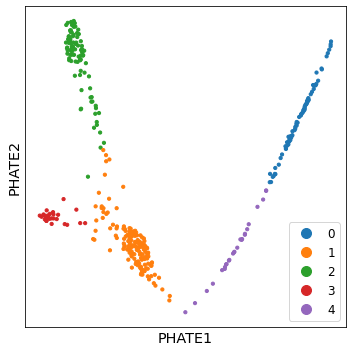

In [14]:
scprep.plot.scatter2d(data_phate, c=metadata['cluster'],
                 label_prefix='PHATE', ticks=None,
                figsize=(5,5))

### Step 3, 4, 5 - Create the minimum spanning tree, fit principal curves, and project data onto curves

These last steps of Slingshot are all performed behind-the-scenes by the Slingshot R package. We're going to leave all of those steps to Slingshot here and access the method using `scprep.run.Slingshot`. You can find the full documentation for the method here: https://scprep.readthedocs.io/en/stable/reference.html#module-scprep.run

#### Run `scprep.run.Slingshot()`

In [15]:
# =======
# Reading the documentation for `scprep.run.Slingshot()` 
# replace the '...' with the correct code.
results = scprep.run.Slingshot(data_phate,
                               metadata['cluster'],
                               start_cluster=1)

# =======

R[write to console]: Using full covariance matrix


#### Grab output from `results` dictionary

In [16]:
pseudotime = results['pseudotime']
metadata['slingshot1'] = pseudotime.iloc[:,0]
metadata['slingshot2'] = pseudotime.iloc[:,1]

metadata['slingshot_branch'] = results['branch']
metadata.head()

,annotated_clusters,cluster,slingshot1,slingshot2,slingshot_branch
0,,,,,
1_iN1_C01,d2_induced,1,0.010775,NaN,4
1_iN1_C02,d2_induced,1,0.014804,NaN,4
1_iN1_C03,d2_induced,1,0.008692,NaN,4
1_iN1_C04,d2_intermediate,4,0.070415,NaN,4
1_iN1_C05,d2_intermediate,4,0.054772,NaN,4


#### Plotting the principal curves


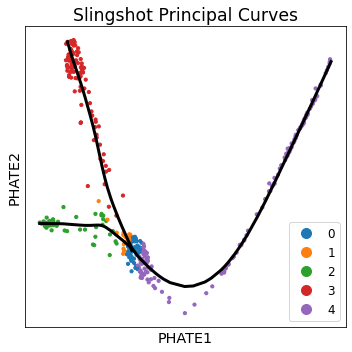

In [17]:
ax = scprep.plot.scatter2d(data_phate, c=metadata['slingshot_branch'],
                 label_prefix='PHATE', ticks=None,
                 title='Slingshot Principal Curves',
                 figsize=(5,5))

# `results['curves']` returns as tensor (an array of arrays)
# Each array contains coordinates for the curves in the dimensionality reduced space
for curve in results['curves']:
    ax.plot(curve[:,0], curve[:,1], c='k', linewidth=3)

### Plotting branch pseudotime

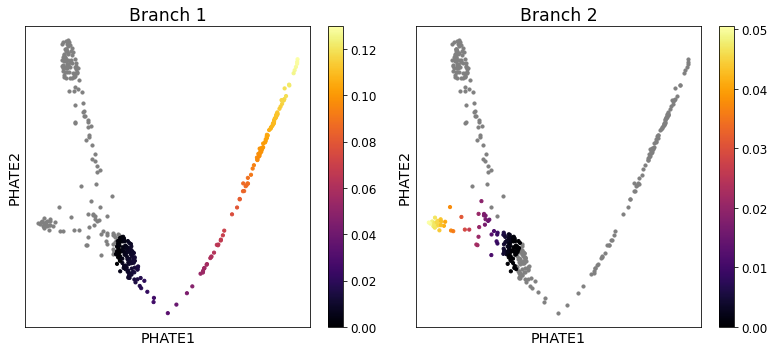

In [18]:
fig, axes = plt.subplots(1,2, figsize=(11,5))

for i, ax in enumerate(axes):
    curr_pseudotime = metadata['slingshot{}'.format(i+1)]
    m = np.isfinite(curr_pseudotime)
    # plot null points as grey
    scprep.plot.scatter2d(data_phate[~m], color='grey', s=10, ax=ax)    
    # plot points on branch
    scprep.plot.scatter2d(data_phate[m], c=curr_pseudotime[m], s=10,
                          label_prefix='PHATE', ticks=None,
                          title='Branch {}'.format(i + 1), ax=ax)
    
fig.tight_layout()

### Plotting clusters by pseudotime

Now we can do something interesting, like figure out the developmental ordering of the various cell types characterized in the `annotated_clusters` metadata variable.

To plot clusters by pseudotime, we're going to use `scprep.plot.jitter()`. Jitterplots are a kind of scatter plot useful for comparing the distribution of values within various classes of data. They are related to [`sns.violinplot`](https://seaborn.pydata.org/generated/seaborn.violinplot.html) and [`sns.swarmplot`](https://seaborn.pydata.org/generated/seaborn.swarmplot.html), but can be plotted much more quickly because the noise on the x-dimension is random Normal.

The grey circles in the center of each column are the means for those classes.

`scprep.plot.jitter` API: https://scprep.readthedocs.io/en/stable/reference.html#scprep.plot.jitter

Jitterplot gallery: https://scprep.readthedocs.io/en/stable/examples/jitter.html

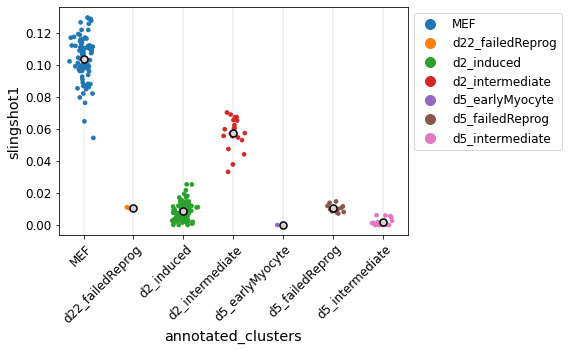

In [21]:
# Get all the cells that are on the desired branch.
curr_branch = 'slingshot1'
mask = np.isfinite(metadata[curr_branch])

# Create Jitterplot
ax = scprep.plot.jitter(metadata['annotated_clusters'].loc[mask], metadata[curr_branch].loc[mask],
                        c=metadata['annotated_clusters'].loc[mask], legend_anchor=(1,1),
                        means_s=50,
                        figsize=(8,4))

# Neaten xticklabels
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
scprep.plot.utils.shift_ticklabels(ax.xaxis, dx=0.15)

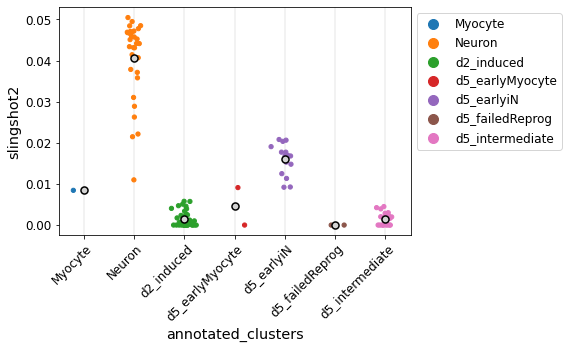

In [20]:
# Get all the cells that are on the desired branch.
curr_branch = 'slingshot2'
mask = np.isfinite(metadata[curr_branch])

# Create Jitterplot
ax = scprep.plot.jitter(metadata['annotated_clusters'].loc[mask], metadata[curr_branch].loc[mask],
                        c=metadata['annotated_clusters'].loc[mask], legend_anchor=(1,1),
                        means_s=50,
                        figsize=(8,4))

# Neaten xticklabels
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
scprep.plot.utils.shift_ticklabels(ax.xaxis, dx=0.15)

### Discussion

In groups, try the following:
1. Each pick a different dimensionality reduction method (UMAP, t-SNE, or PCA).
2. Each pick a different clustering method (see earlier exercises for code).
3. Rerun Slingshot
4. Compare results

In groups, discuss the following questions:
1. Do these orderings make sense given the cluster labels? Why?
- some of the annotated call types are very similar to one another on the PHATE plot, so it's unsurprising that their pseudotime values are also very similar. However, on a macro level, Slinshot seems to do a good job of arranging the cells in order
2. How does choice of dimensionality reduction tool affect the output of Slingshot?
- it makes an immense difference. Particularly noteworthy is the inappropriateness of t-SNE (and to a lesser extent UMAP): these methods break up the data into clusters with somewhat arbitrary (or in the case of t-SNE, completely arbitrary) positions, which makes Slingshot's job impossible
3. Does choice of dimensionality reduction tool or cluster method have more impact on output?
- the choice of dimensionality reduction has the largest effect

## Running Diffusion Pseudotime

In this section, we're going to use the diffusion pseudotime algorithm implemented in `scanpy`, a scRNA-seq analysis toolkit from Alex Wolf and the Theis Lab. The Theis lab were the inventors of the algorithm, so we're going to use their implementation to provide a comparison to Slingshot. As this MEF dataset is fairly simply, we don't expect to see huge differences between the algorithms. 

Because `scanpy` is a Python package, we can just use their code directly. The documentation for the `scanpy.tl.dpt` function can be found here: https://icb-scanpy.readthedocs-hosted.com/en/stable/api/scanpy.api.tl.dpt.html.

#### About the  `AnnData` object

All of the `scanpy` functions expect data to be organized in an `AnnData` object. The idea behind `AnnData` is to have a single container for all of the data and metadata associated with a single cell experiment. The `AnnData` class is useful and flexible. We don't use the `AnnData` class elsewhere in the workshop because we prefer to directly interact with Pandas `DataFrame` objects which are a more generic data container. The `DataFrame` is a useful data container for almost any kind of data one might work with, while `AnnData` is designed around gene expression data.

You very well may find that you prefer working with `AnnData` objects because of the handy single-cell functionality built into `scanpy`. If you want to learn more about them, check out the official `AnnData` documentation here: https://anndata.readthedocs.io.

### Running DPT

The workflow here is fairly simple. We're going to put the data in an `Anndata` container, run PCA, calculate NearestNeighbors, and DiffusionMaps. With that done, we are ready to run DPT.

In [22]:
# Here we create an AnnData container
adata = anndata.AnnData(data)

# DPT requires a root cell, depending on the orientation of your
# plot, you should be able to use the cell with the highest 
# data_phate[:,0] coordinate
adata.uns['iroot'] = np.argmax(data_phate.iloc[:,0].values)

# Run PCA
scanpy.pp.pca(adata)

# Identify nearest neighbors
scanpy.pp.neighbors(adata)

# Create the diffusion map
scanpy.tl.diffmap(adata)

# Run Diffusion Pseudotime with 1 branching event
scanpy.tl.dpt(adata, n_branchings=1)

# Grab the output and store in our metadata DataFrame
metadata['dpt'] = adata.obs['dpt_pseudotime']
metadata['dpt_branch'] = adata.obs['dpt_groups'].astype(int)
metadata.head()

,annotated_clusters,cluster,slingshot1,slingshot2,slingshot_branch,dpt,dpt_branch
0,,,,,,,
1_iN1_C01,d2_induced,1,0.010775,NaN,4,0.760835,2
1_iN1_C02,d2_induced,1,0.014804,NaN,4,0.757309,2
1_iN1_C03,d2_induced,1,0.008692,NaN,4,0.768130,2
1_iN1_C04,d2_intermediate,4,0.070415,NaN,4,0.203582,2
1_iN1_C05,d2_intermediate,4,0.054772,NaN,4,0.310838,2


### Plotting pseudotime and branch assignments

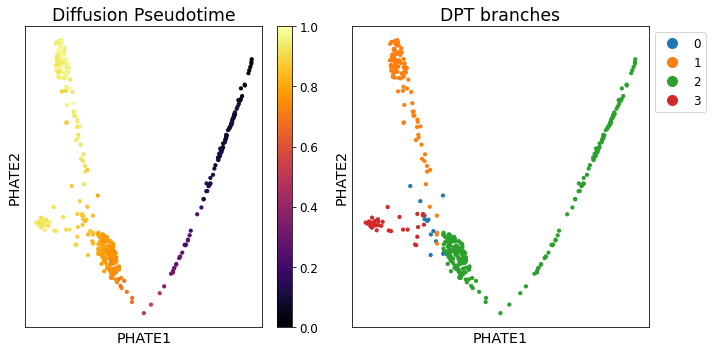

In [23]:
fig, axes = plt.subplots(1,2, figsize=(10,5))

ax = scprep.plot.scatter2d(data_phate, c=metadata['dpt'], 
                           ticks=None, label_prefix='PHATE',
                           title='Diffusion Pseudotime',
                           ax=axes[0])

scprep.plot.scatter2d(data_phate, c=metadata['dpt_branch'], 
                      ticks=None, label_prefix='PHATE',
                      title='DPT branches',
                      legend_anchor=(1,1),
                      ax=axes[1])

fig.tight_layout()

## Plotting clusters by pseudotime

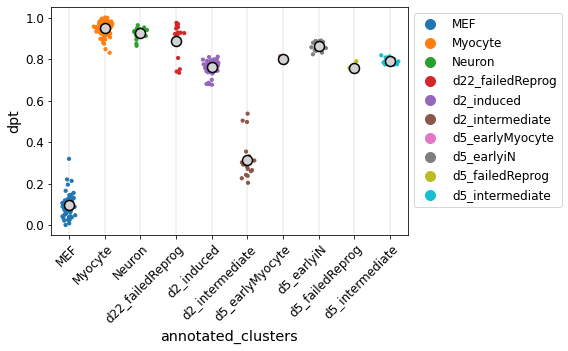

In [24]:
ax = scprep.plot.jitter(metadata['annotated_clusters'], metadata['dpt'], 
                        c=metadata['annotated_clusters'], legend_anchor=(1,1), figsize=(8,4))

ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
scprep.plot.utils.shift_ticklabels(ax.xaxis, dx=0.15)

## Comparing DPT vs Slingshot

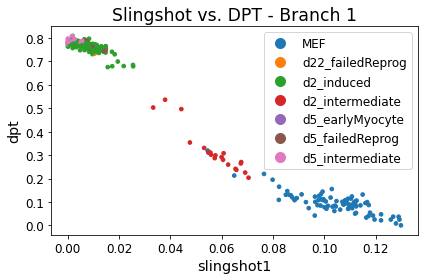

In [25]:
# Get all the cells that are on the desired branch.
curr_branch = 'slingshot1'
mask = np.isfinite(metadata[curr_branch])

ax = scprep.plot.scatter(metadata[curr_branch].loc[mask], metadata['dpt'].loc[mask],
                         c=metadata['annotated_clusters'].loc[mask],
                         title='Slingshot vs. DPT - Branch 1',
                         legend_anchor=(1,1))

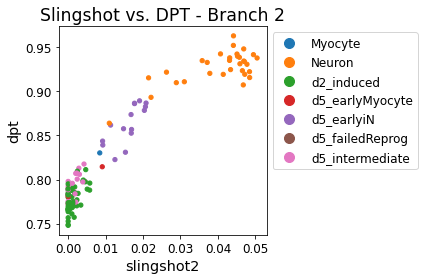

In [26]:
# Get all the cells that are on the desired branch.
curr_branch = 'slingshot2'
mask = np.isfinite(metadata[curr_branch])

ax = scprep.plot.scatter(metadata[curr_branch].loc[mask], metadata['dpt'].loc[mask],
                         c=metadata['annotated_clusters'].loc[mask],
                         title='Slingshot vs. DPT - Branch 2',
                         legend_anchor=(1,1))

### Optional - Plotting genes by pseudotime

Try plotting genes like `Vim`, `Fn1`, `Ascl1`, `Myl1`, or `Stemn3` against either slingshot or diffusion pseudotime. 

### Discussion

In groups, discuss the following questions:

1. How well do the pseudotime orderings from Slingshot and DPT agree?
- the orderings agree fairly well, even if the exact values are quite different
2. How could you quantify this?
- could compute Spearman correlation in order to determine the similarity in ordering
3. Notice how there is a gap in pseudotime identified by both methods. Why do you think this happens? Provide both an algorithmic explanation (mathematically why is there a gap) and a biologically plausible explanation (what does this suggest about differentiation)?
- mathematically: the graph is somewhat disconnected in the middle. This causes a low transition probability between the MEF/intermediate section and the Myocite/Neuron section, which increases the a) distance on the PHATE plot (and hence the Slingshot pseudotime) and b) the diffusion pseudotime directly
- Biologically: there is a rapid differentiation process between intermediate cells and progenitors, such that very few cells are observed in between these populations.